In [1]:
# !ollama list

In [2]:
from langchain_tavily import TavilySearch
from dotenv import load_dotenv, find_dotenv
import os 
from langchain_ollama import ChatOllama
from langgraph.prebuilt import create_react_agent
from langchain.document_loaders import UnstructuredExcelLoader,PyPDFLoader
from langchain.chains import ConversationalRetrievalChain,load_summarize_chain
from langchain.memory import ConversationBufferMemory
load_dotenv(find_dotenv(), override=True)
from langchain_chroma import Chroma
from langchain_openai import OpenAIEmbeddings

from langchain_core.vectorstores import InMemoryVectorStore
memory = ConversationBufferMemory(memory_key="chat_history", return_messages=True,output_key='answer')
embeddings = OpenAIEmbeddings(model="text-embedding-3-large")

credit_policy_vector_store = Chroma(
    collection_name="credit_policy_collection",
    embedding_function=embeddings,
    persist_directory="./credit_policy_db",
)

llm = ChatOllama(model="GandalfBaum/llama3.2-claude3.7:latest",temperature=0.1)

/var/folders/66/z_b55kvs5xxbskrymwm96gm00000gn/T/ipykernel_38540/3768548524.py:14: LangChainDeprecationWarning: Please see the migration guide at: https://python.langchain.com/docs/versions/migrating_memory/
  memory = ConversationBufferMemory(memory_key="chat_history", return_messages=True,output_key='answer')


In [3]:
def credit_risk_evaluation(emirates_id:str):

    """ Looks up the credit risk policies. """
    
    credit_report_file_path = f"credit-reports/{emirates_id}.pdf"
    loader = PyPDFLoader(credit_report_file_path)
    docs = loader.load_and_split()
    
    chain = load_summarize_chain(llm, chain_type="stuff",verbose=False)
    
    summary = chain.invoke(docs)
    final_summary = summary['output_text']

    query = f"""
        Given the below summary of the credit report of an applicant, check whether the applicant 
        is elligible  for financial support given the credit policy rules. 
        
        Credit report Summary: 
        {final_summary} \n\n        
        """
    
    retriever = credit_policy_vector_store.as_retriever(
        search_type="mmr", search_kwargs={"k": 1, "fetch_k":2}
    )

    conversational_retrieval = ConversationalRetrievalChain.from_llm(
        llm=llm,retriever=retriever, memory=memory,verbose=False
    )
    return conversational_retrieval.invoke(query)["answer"]  


credit_risk_evaluator_agent = create_react_agent(
    model=llm,
    tools=[credit_risk_evaluation],
    prompt=(
        "You are a Credit Risk Evaluation Agent.\n\n"
        "INSTRUCTIONS:\n"
        "- Your job is to assess whether the applicant's credit report violates any financial support policies.\n"
        "- Use the available tools to retrieve and analyze relevant credit policy documents.\n"
        "- Extract matching policies or clauses using semantic search and base your evaluation on those.\n"
        "- Respond with ONLY the compliance result, the matched policies, and your risk assessment.\n"
        "- DO NOT explain your reasoning or add extra commentary.\n"
        "- Once your analysis is complete, send the structured result back to the supervisor.\n\n"
        "Your final output must only contain the following attributes:\n"
        "  credit_risk: \"High\" or \"Low\",\n"
        "  policy_matches: [\"DTI >=<number>\"],\n"
        "  compliance_flag: true or false"
    ),
    name="credit_risk_evaluator_agent"
)

def summarize_bank_statements(emirates_id:str):
    """
    Summarizes the bank statements of the applicants
    """

    query = """Summarize the transactions in the given bank statement for last 30 days, make a note of the key transactions,
            overall expenses that will contribute to the applicants economic support plan and total amount available in the users bank account            
    """
    
    bank_statement_path = f"bank-statements/{emirates_id}.xlsx"
    loader = UnstructuredExcelLoader(bank_statement_path)
    
    bank_statement_docs = loader.load()
    
    bank_statements_vector_store = InMemoryVectorStore(embeddings)
    bank_statements_vector_store.add_documents(documents=bank_statement_docs)

    bank_statement_retriever = bank_statements_vector_store.as_retriever(
        search_type="mmr",
        search_kwargs={"k": 1, "fetch_k": 2, "lambda_mult": 0.5},
    )
    conversational_retrieval = ConversationalRetrievalChain.from_llm(
        llm=llm,retriever=bank_statement_retriever, memory=memory,verbose=False
    )

    return conversational_retrieval.invoke(query)["answer"]

financial_burden_agent = create_react_agent(
    model=llm,
    tools=[summarize_bank_statements],
    prompt=(
        "You are a Financial Hardship Assessment Agent.\n\n"
        "INSTRUCTIONS:\n"
        "- Your job is to calculate the applicant’s true financial hardship based on their income, liabilities, and number of dependents.\n"
        "- Use the available tools to retrieve and summarize the applicant’s bank statements, loan obligations, and dependent count.\n"
        "- Compute key metrics: debt-to-income ratio, monthly disposable income after liabilities, and per-dependent allocation.\n"
        "- Respond with ONLY a JSON object containing these metrics and an overall hardship classification (High, Moderate, Low).\n"
        "- Your final JSON must include exactly the following fields:\n"
        "  net_worth,\n"
        "  debt_to_income,\n"
        "  burden_score\n"
        "- Do NOT include any other keys, explanations, or commentary.\n"
        "- Return the structured result back to the supervisor when complete."
    ),
    name="financial_burden_agent"
)

In [4]:
from langchain_core.messages import convert_to_messages

def pretty_print_message(message, indent=False):
    pretty_message = message.pretty_repr(html=True)
    if not indent:
        print(pretty_message)
        return

    indented = "\n".join("\t" + c for c in pretty_message.split("\n"))
    print(indented)


def pretty_print_messages(update, last_message=False):
    is_subgraph = False
    if isinstance(update, tuple):
        ns, update = update
        # skip parent graph updates in the printouts
        if len(ns) == 0:
            return

        graph_id = ns[-1].split(":")[0]
        print(f"Update from subgraph {graph_id}:")
        print("\n")
        is_subgraph = True

    for node_name, node_update in update.items():
        update_label = f"Update from node {node_name}:"
        if is_subgraph:
            update_label = "\t" + update_label

        print(update_label)
        print("\n")

        messages = convert_to_messages(node_update["messages"])
        if last_message:
            messages = messages[-1:]

        for m in messages:
            pretty_print_message(m, indent=is_subgraph)
        print("\n")

In [5]:
emirates_id = "1234"
applicant_data = {
    "CurrentlyEmployed": "No",
    "last_drawn_salary": "12000 AED",
    "last_employment_date": "05-10-2024",
    "marital_status": "Yes",
    "num_children": 3
}

query = f"""
        Applicant Emirates ID: {emirates_id}. Here is their data: {applicant_data}. "
        """

for chunk in credit_risk_evaluator_agent.stream(
    {"messages": [{"role": "user", "content": query}]}
):
    pretty_print_messages(chunk)

Update from node agent:


================================== Ai Message ==================================
Name: credit_risk_evaluator_agent
Tool Calls:
  credit_risk_evaluation (67e768d1-8654-4bde-9b2d-1e2f5ce8703f)
 Call ID: 67e768d1-8654-4bde-9b2d-1e2f5ce8703f
  Args:
    emirates_id: 1234


Update from node tools:


================================= Tool Message =================================
Name: credit_risk_evaluation

Based on the provided credit report summary, I would say that Lionel M is not eligible for financial support at this time.

The reasons are:

1. High outstanding amounts (AED 913,700) which indicates a significant debt burden.
2. Poor payment history, which suggests a lack of responsibility in managing his finances.
3. A poor credit score of 520, which is considered subprime and may indicate a high risk for the lender.

The recommendations provided suggest that Lionel needs to address these issues before he can be considered eligible for financial support. Spec

In [7]:
from typing import Annotated
from langchain_core.tools import tool, InjectedToolCallId
from langgraph.prebuilt import InjectedState
from langgraph.graph import StateGraph, START, MessagesState
from langgraph.types import Command

def create_handoff_tool(*, agent_name: str, description: str | None = None):
    name = f"transfer_to_{agent_name}"
    description = description or f"Ask {agent_name} for help."

    @tool(name, description=description)
    def handoff_tool(
        state: Annotated[MessagesState, InjectedState],
        tool_call_id: Annotated[str, InjectedToolCallId],
    ) -> Command:
        tool_message = {
            "role": "tool",
            "content": f"Successfully transferred to {agent_name}",
            "name": name,
            "tool_call_id": tool_call_id,
        }
        # highlight-next-line
        return Command(
            # highlight-next-line
            goto=agent_name,  # (1)!
            # highlight-next-line
            update={**state, "messages": state["messages"] + [tool_message]},  # (2)!
            # highlight-next-line
            graph=Command.PARENT,  # (3)!
        )

    return handoff_tool


assign_to_credit_risk_agent = create_handoff_tool(
    agent_name="credit_risk_evaluator_agent",
    description="Assign task to a credit risk evaluator agent.",
)

assign_to_finance_evaluator_agent = create_handoff_tool(
    agent_name="financial_burden_agent",
    description="Assign task to a financial burden agent.",
)

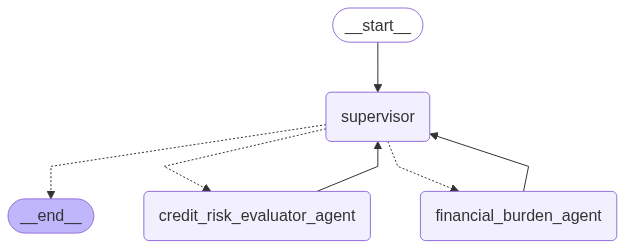

In [8]:
supervisor_agent = create_react_agent(
    model=llm,
    tools=[assign_to_credit_risk_agent, assign_to_finance_evaluator_agent],
    prompt=(
        "You are the Social Support Application Supervisor.\n"
        "You have two agents:\n"
        "- financial_burden_agent: calculates true financial hardship and returns JSON with net_worth, debt_to_income, burden_score.\n"
        "- credit_risk_evaluator_agent: evaluates credit risk and returns JSON with credit_risk, policy_matches, compliance_flag.\n\n"
        "When a user query arrives:\n"
        "  1. Delegate the request to both the agents one after the other (only one request per agent).\n"
        "  2. After you receive that agent’s output, use both sets of attributes to derive the final recommendation.\n\n"
        "Your final decision should be based on below logic examples:\n"
        "- If credit_risk is \"Low\" AND debt_to_income < 0.5 AND burden_score < 0.5 AND compliance_flag is true → Approved\n"
        "- If credit_risk is \"High\" OR debt_to_income > 0.8 OR burden_score > 0.8 OR compliance_flag is false → Soft Decline\n"
        "- Otherwise → Approved with Conditions\n\n"
        "The final response must only contain a JSON object as below:\n"
        "  financial_support_decision: \"Approved\" | \"Soft Decline\" | \"Approved with Conditions\",\n"
        "  reason: a brief phrase like \"Low burden and acceptable credit\" or \"High debt-to-income ratio\"\n"
    ),
    name="supervisor",
)

from langgraph.graph import END
supervisor = (
    StateGraph(MessagesState)
    # NOTE: `destinations` is only needed for visualization and doesn't affect runtime behavior
    .add_node(supervisor_agent, destinations=("credit_risk_evaluator_agent", "financial_burden_agent", END))
    .add_node(credit_risk_evaluator_agent)
    .add_node(financial_burden_agent)
    .add_edge(START, "supervisor")
    # always return back to the supervisor
    .add_edge("credit_risk_evaluator_agent", "supervisor")
    .add_edge("financial_burden_agent", "supervisor")
    .compile()
)

from IPython.display import display, Image

display(Image(supervisor.get_graph().draw_mermaid_png()))

In [9]:
emirates_id = "1234"
applicant_data = {
    "CurrentlyEmployed": "No",
    "last_drawn_salary": "12000 AED",
    "last_employment_date": "05-10-2024",
    "marital_status": "Yes",
    "num_children": 3
}

query = f"""
        Applicant Emirates ID: {emirates_id}. Here is their data: {applicant_data}. "
        """

for chunk in financial_burden_agent.stream(
    {"messages": [{"role": "user", "content": query}]}
):
    pretty_print_messages(chunk)

Update from node agent:


================================== Ai Message ==================================
Name: financial_burden_agent
Tool Calls:
  summarize_bank_statements (f9fad48f-b996-4593-ba88-8724138d8db2)
 Call ID: f9fad48f-b996-4593-ba88-8724138d8db2
  Args:
    emirates_id: 1234


Update from node tools:


================================= Tool Message =================================
Name: summarize_bank_statements

I don't know Lionel, but I can help you with the information provided. The data appears to be a bank statement for an individual, but there is no mention of a person named Lionel.

However, based on the provided data, I can summarize the transactions over the past 30 days and calculate some key expenses that might contribute to economic support:

**Summary of Transactions:**

The transactions are categorized into various types, including Government Aid, School Fees, Credit Refund, Personal Loan EMI, Mortgage EMI, Dubai Metro Transport, DEWA Utilities, Lulu Hyp

GraphRecursionError: Recursion limit of 25 reached without hitting a stop condition. You can increase the limit by setting the `recursion_limit` config key.
For troubleshooting, visit: https://python.langchain.com/docs/troubleshooting/errors/GRAPH_RECURSION_LIMIT

In [ ]:
for chunk in supervisor.stream(
    {
        "messages": [
            {
                "role": "user",
                "content": query,
            }
        ]
    },
):
    pretty_print_messages(chunk, last_message=True)

final_message_history = chunk["supervisor"]["messages"]

In [ ]:
# for message in final_message_history:
#     message.pretty_print()

In [ ]:
from langgraph.types import Send

def create_task_description_handoff_tool(
    *, agent_name: str, description: str | None = None
):
    name = f"transfer_to_{agent_name}"
    description = description or f"Ask {agent_name} for help."

    @tool(name, description=description)
    def handoff_tool(
        # this is populated by the supervisor LLM
        task_description: Annotated[
            str,
            "Description of what the next agent should do, including all of the relevant context.",
        ],
        # these parameters are ignored by the LLM
        state: Annotated[MessagesState, InjectedState],
    ) -> Command:
        task_description_message = {"role": "user", "content": task_description}
        agent_input = {**state, "messages": [task_description_message]}
        return Command(
            # highlight-next-line
            goto=[Send(agent_name, agent_input)],
            graph=Command.PARENT,
        )

    return handoff_tool

assign_to_credit_risk_agent_with_description = create_handoff_tool(
    agent_name="credit_risk_evaluator_agent",
    description="Assign task to a credit risk evaluator agent.",
)

assign_to_finance_evaluator_agent_with_description = create_handoff_tool(
    agent_name="financial_burden_agent",
    description="Assign task to a financial burden agent.",
)


supervisor_agent_with_description = create_react_agent(
    model=llm,
    tools=[
        assign_to_credit_risk_agent_with_description,
        assign_to_finance_evaluator_agent_with_description,
    ],
     prompt=(
        "You are the Social Support Application Supervisor.\n"
        "You have two agents:\n"
        "- financial_burden_agent: calculates true financial hardship and returns JSON with net_worth, debt_to_income, burden_score.\n"
        "- credit_risk_evaluator_agent: evaluates credit risk and returns JSON with credit_risk, policy_matches, compliance_flag.\n\n"
        "When a user query arrives:\n"
        "  1. Delegate the request to both the agents one after the other(only one request per agent).\n"
        "  2. After you receive that agent’s output, use both sets of attributes to derive the final recommendation.\n\n"
        "Your final decision should be based on below logic examples:\n"
        "- If credit_risk is \"Low\" AND debt_to_income < 0.5 AND burden_score < 0.5 AND compliance_flag is true → Approved\n"
        "- If credit_risk is \"High\" OR debt_to_income > 0.8 OR burden_score > 0.8 OR compliance_flag is false → Soft Decline\n"
        "- Otherwise → Approved with Conditions\n\n"
        "The final response must only contain a JSON object as below:\n"
        "  financial_support_decision: \"Approved\" | \"Soft Decline\" | \"Approved with Conditions\",\n"
        "  reason: a brief phrase like \"Low burden and acceptable credit\" or \"High debt-to-income ratio\"\n"
    ),
    name="supervisor",
)

supervisor = (
    StateGraph(MessagesState)
    # NOTE: `destinations` is only needed for visualization and doesn't affect runtime behavior
    .add_node(supervisor_agent, destinations=("credit_risk_evaluator_agent", "financial_burden_agent", END))
    .add_node(credit_risk_evaluator_agent)
    .add_node(financial_burden_agent)
    .add_edge(START, "supervisor")
    # always return back to the supervisor
    .add_edge("credit_risk_evaluator_agent", "supervisor")
    .add_edge("financial_burden_agent", "supervisor")
    .compile()
)

In [ ]:
for chunk in supervisor.stream(
    {
        "messages": [
            {
                "role": "user",
                "content": query,
            }
        ]
    },
):
    pretty_print_messages(chunk, last_message=True)

final_message_history = chunk["supervisor"]["messages"]